In [24]:
!pip install coverage
!pip install emoji
!pip install pytest pytest-cov
!pip install beautifulsoup4
!pip install email_validator

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#Test Fuzzer

In [21]:
import random
import string
import coverage
from collections import defaultdict
import tempfile
import os
import subprocess
import unicodedata
import inspect
import heapq
import importlib
import sys
import json

In [42]:
import random

class SemiPriorityQueue:
    def __init__(self):
        self.queue = []
        self.serial_counter = 0  # Initialize a serial counter
    
    def push(self, item, score):
        """Add an item with a given score and track its push serial."""
        self.queue.append((score, item, self.serial_counter))  # Include serial in the tuple
        self.serial_counter += 1  # Increment the serial counter
    
    def pop(self):
        """Remove and return an item, favoring higher scores probabilistically."""
        if not self.queue:
            raise IndexError("pop from an empty priority queue")
        
        scores, items, _ = zip(*self.queue)  # Separate scores, items, and serials
        selected = random.choices(self.queue, weights=scores, k=1)[0]  # Weighted random choice
        self.queue.remove(selected)  # Remove selected item
        return selected[1]  # Return only the item
    
    def peek(self):
        """Return an item that is more likely to be popped next (does not remove it)."""
        if not self.queue:
            return None
        scores, items, _ = zip(*self.queue)
        selected = random.choices(items, weights=scores, k=1)[0]
        return selected
    
    def is_empty(self):
        """Check if the queue is empty."""
        return len(self.queue) == 0
    
    def size(self):
        """Return the number of elements in the queue."""
        return len(self.queue)
    
    def __str__(self):
        """Return a string representation of the queue."""
        return str(sorted(self.queue, reverse=True))  # Sort by score for visualization

    def get_serial(self, item):
        """Get the serial of an item."""
        for score, queue_item, serial in self.queue:
            if queue_item == item:
                return serial
        return None  # Return None if the item isn't found


# Smart Fuzzer

class SmartFuzzer:
    def __init__(self, initial_seed, trial=1000, alphabet=None):
        self.max_iterations = trial
        self.coverage_data = defaultdict(int)

        if alphabet is not None:
            self.alphabet = alphabet
        elif type(initial_seed) == type(1):
            self.alphabet = self.generate_integer_alphabet()
        elif type(initial_seed) == type(1.0):
            self.alphabet = self.generate_double_alphabet()
        else:
            self.alphabet = self.generate_alphabet()
        
        self.alphabet_length = len(self.alphabet)
        self.initial_seed = initial_seed

    def generate_alphabet(self):
        """
        This method creates alphabet with english and special characters
        Parameters:
        None
        Returns:
        str: alphabet
        """
        # English Alphabet
        english = string.ascii_letters + string.digits + string.punctuation
        # Special Characters (common punctuation and symbols)
        # special_chars = string.punctuation + ''.join(chr(i) for i in range(0x2000, 0x206F))  # Additional special characters
        # Combine all characters into one string
        combined_characters = english # + special_chars

        # Remove duplicates while preserving order
        seen = set()
        unique_characters = []
        for char in combined_characters:
            if char not in seen:
                unique_characters.append(char)
                seen.add(char)

        # Return the result as a string
        return ''.join(unique_characters)

    def generate_double_alphabet():
        return string.digits + '.' + 'e' + "-"

    def generate_integer_alphabet():
        return string.digits + "-"
    
    def delete_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 1:
            index = random.sample(range(0, len(input_list)), 1)
            del input_list[index[0]]
            return input_list
        else:
            return self.replace_char(inp)
        
    def insert_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) == 0:
            index = [0]
        else:
            index = random.sample(range(0, len(input_list)), 1)
        input_list.insert(index[0], random.choice(list(self.alphabet)))
        return input_list
    
    def reverse(self, inp):
        input_list = list(str(inp))
        input_list = input_list[::-1]
        return input_list
    
    def append_char(self, inp):
        input_list = list(str(inp))
        input_list.append(random.choice(list(self.alphabet)))
        return input_list
    
    def replace_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 1:
            replace_trial = 10
            while(replace_trial > 0):
                index = random.sample(range(0, len(input_list)), 1)
                in_place_digit = input_list[index[0]]
                replaced_digit = random.choice(list(self.alphabet))
                if in_place_digit != replaced_digit:
                    break
                else:
                    replace_trial -= 1

            input_list[index[0]] = replaced_digit
            return input_list
        else:
            return self.append_char(inp)
        
    def flip_2_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 2:
            flip_trial = 10
            while(flip_trial > 0):
                random_integers = random.sample(range(0, len(input_list)), 2)
                index1 = random_integers[0]
                number_at_index1 = input_list[index1]
                index2 = random_integers[1]
                number_at_index2 = input_list[index2]
                if number_at_index1 != number_at_index2:
                    break
                else:
                    flip_trial -= 1
            
            input_list[index1] = number_at_index2
            input_list[index2] = number_at_index1

            return input_list
        else:
            return self.replace_char(inp)
        
    def mutate_inp(self, inp):
        """
        Provides a mutated version of an input
        Parameters:
        inp: input
        Returns:
        mutated input
        """
        mutation_type = random.choice(["flip", "replace", "append", "delete", "insert", "reverse"])
        input_list = list(str(inp))
        print(f"mutation type selected: {mutation_type}")
        
        if mutation_type == "flip":
            input_list = self.flip_2_char(inp)
        elif mutation_type == "replace" and input_list:
            input_list = self.replace_char(inp)
        elif mutation_type == "append":
            input_list = self.append_char(inp)
        elif mutation_type == "delete" and input_list:
            input_list = self.delete_char(inp)
        elif mutation_type == "insert":
            input_list = self.insert_char(inp)
        elif mutation_type == "reverse":
            input_list = self.reverse(inp)

        mutated_inp = "".join(input_list)

        return mutated_inp
    
    def mutate(self, inp):
        while(True):
            mutated_inp = self.mutate_inp(inp)
            if type(inp) == type(""):
                return mutated_inp
            elif type(inp) == type(1):
                mutation_trial = 10
                while(mutation_trial > 0):
                    try:
                        mutated_inp = int(mutated_inp)
                        return int(mutated_inp)
                    except:
                        mutation_trial -= 1
                return None
            elif type(inp) == type(1.0):
                mutation_trial = 10
                while(mutation_trial > 0):
                    try:
                        mutated_inp = float(mutated_inp)
                        return float(mutated_inp)
                    except:
                        mutation_trial -= 1
                return None

In [4]:
%%file example_function1.py

# Example usage
def sample_function(input_str):
    if "bug" in input_str:
        print("Found a bug!")
    elif "bun" in input_str:
        print("BUN")
    elif "bus" in input_str:
        print("BUS")
    elif "but" in input_str:
        print("BUT")
    elif "buz" in input_str:
        print("BUZ")
    elif "buga" in input_str:
        print("BUGA")
    elif "bugs" in input_str:
        print("BUGS")
    elif "buge" in input_str:
        print("BUGE")
    elif "gub" in input_str:
        print("GUB")
    elif "error" in input_str:
        print("Potential issue detected.")
    elif "warning" in input_str:
        print("Non-critical warning.")
    elif "fail" in input_str:
        print("System failure detected!")
    elif "1234" in input_str:
        print("Processing sensitive input...")
    elif input_str.startswith("admin"):
        print("Admin privileges detected.")
    elif "debug" in input_str and "log" in input_str:
        print("Debugging mode enabled.")
    elif "safe" in input_str or "secure" in input_str:
        print("Security mode active.")
    elif len(input_str) > 10:
        print("Handling long input...")
    elif input_str.isdigit():
        print("Processing numeric input.")
    elif "!" in input_str and "?" in input_str:
        print("Detected a confused input!")
    else:
        print(f"Processing {input_str}")


Overwriting example_function1.py


In [39]:
import subprocess
import xml.etree.ElementTree as ET
import random
from collections import defaultdict
# from semipriorityqueue import SemiPriorityQueue  # Assuming you save SemiPriorityQueue in semipriorityqueue.py
# from smartfuzzer import SmartFuzzer  # Assuming you save SmartFuzzer in smartfuzzer.py

def parse_coverage_report(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # coverage_data = {}
    total_line_covered = 0
    total_lines = 0
    for file in root.findall(".//class"):
        filename = file.get('filename')
        for line in file.findall('lines/line'):
            total_lines += 1
            line_num = int(line.get('number'))
            hits = int(line.get('hits'))
            # coverage_data[str(line_num)] = {'missed': 1 if hits == 0 else 0, 'covered': hits}
            if hits != 0:
                total_line_covered += 1

    return total_line_covered / total_lines

def get_coverage(target_filename_wihout_extension, inp):
    """Runs pytest and extracts the total number of covered lines."""
    try:
        subprocess.run(["pytest", f"--cov={target_filename_wihout_extension}", "--cov-report=xml", "-s", "-q", "--tb=short", "test.py"],
                       check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        covered_lines = parse_coverage_report("coverage.xml")
        return covered_lines
    except Exception as e:
        print(f"Error getting coverage: {e} for input: {inp}")
        return 0


In [47]:
# Initialize the semi-priority queue and fuzzer
queue = SemiPriorityQueue()
initial_seed = "bug"
fuzzer = SmartFuzzer(initial_seed)

# Run 100 fuzzing iterations
for _ in range(100):
    if queue.is_empty():
        new_seed = initial_seed  # Start with the initial seed
    else:
        new_seed = queue.peek()  # Get a prioritized input
    
    mutated_seed = fuzzer.mutate(new_seed)  # Mutate the seed
    
    # Update test.py with the new seed
    with open("test.py", "w") as test_file:
        test_file.write(f"""
from example_function1 import sample_function
import unittest

class TestCheckNumber(unittest.TestCase):
    def test_1(self):
        sample_function({repr(mutated_seed)})

if __name__ == "__main__":
    unittest.main()
        """)
    
    # Run tests and get coverage score
    coverage_score = get_coverage("example_function1", mutated_seed)
    # Push the new mutated input into the priority queue with its score
    if coverage_score is not None and coverage_score > 0:
        queue.push(mutated_seed, coverage_score)

print("Fuzzing completed!")
print(queue.queue)


mutation type selected: delete
mutation type selected: replace
mutation type selected: append
mutation type selected: delete
mutation type selected: insert
mutation type selected: replace
mutation type selected: flip
mutation type selected: append
mutation type selected: replace
mutation type selected: flip
mutation type selected: replace
mutation type selected: replace
mutation type selected: append
mutation type selected: reverse
mutation type selected: reverse
mutation type selected: append
mutation type selected: flip
mutation type selected: delete
mutation type selected: flip
mutation type selected: replace
mutation type selected: append
mutation type selected: replace
mutation type selected: delete
mutation type selected: flip
mutation type selected: delete
mutation type selected: flip
mutation type selected: insert
mutation type selected: flip
mutation type selected: reverse
mutation type selected: flip
mutation type selected: append
mutation type selected: reverse
mutation type

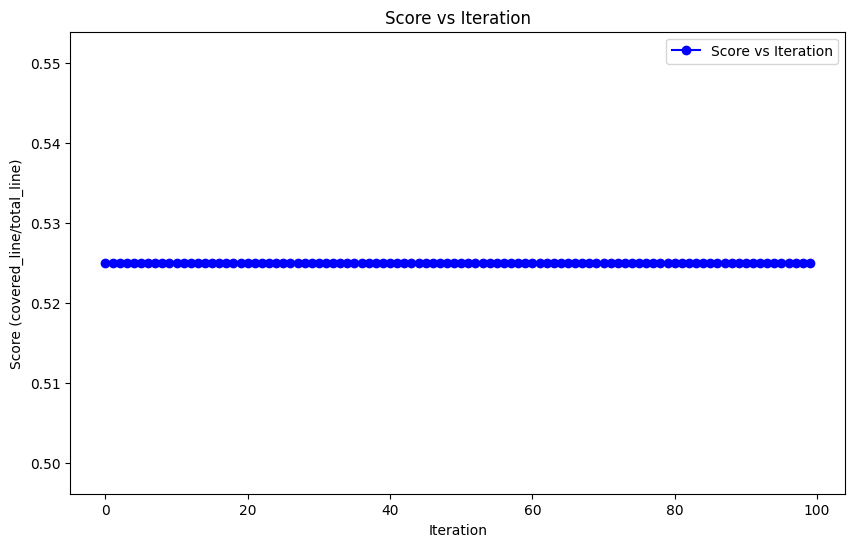

In [48]:
import matplotlib.pyplot as plt

# Your input list
data = queue.queue

# Step 1: Sort the list by iteration value (ascending)
data_sorted = sorted(data, key=lambda x: x[2])

# Step 2: Extract iteration and score values
iterations = [item[2] for item in data_sorted]
scores = [item[0] for item in data_sorted]

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label='Score vs Iteration')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Score (covered_line/total_line)')
plt.title('Score vs Iteration')
plt.legend()

# Show the plot
plt.show()

In [45]:
# Initialize the semi-priority queue and fuzzer
queue = SemiPriorityQueue()
initial_seed = "xyz.adhsd@yahoo.co"
fuzzer = SmartFuzzer(initial_seed)

# Run 100 fuzzing iterations
for _ in range(100):
    if queue.is_empty():
        new_seed = initial_seed  # Start with the initial seed
    else:
        new_seed = queue.peek()  # Get a prioritized input
    
    mutated_seed = fuzzer.mutate(new_seed)  # Mutate the seed
    
    # Update test.py with the new seed
    with open("test.py", "w") as test_file:
        test_file.write(f"""
from email_validator import validate_email, EmailNotValidError
import unittest

class TestCheckNumber(unittest.TestCase):
    def test_1(self):
        try:
            validate_email({repr(mutated_seed)})
        except EmailNotValidError:
            pass
        except Exception as e:
            with open("validate_email.txt", "a") as f:
                f.write(f"Error for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

if __name__ == "__main__":
    unittest.main()
    """)
    try:
        # Run tests and get coverage score
        coverage_score = get_coverage("email_validator", mutated_seed)
        # Push the new mutated input into the priority queue with its score
        if coverage_score is not None and coverage_score > 0:
            queue.push(mutated_seed, coverage_score)
    except Exception as e:
        with open("validate_email.txt", "a") as f:
            f.write(f"Could not generate coverage for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

print("Fuzzing completed!")
print(queue.queue)


mutation type selected: replace
mutation type selected: flip
mutation type selected: reverse
mutation type selected: reverse
mutation type selected: delete
mutation type selected: delete
mutation type selected: flip
mutation type selected: reverse
mutation type selected: append
mutation type selected: append
mutation type selected: flip
mutation type selected: reverse
mutation type selected: append
mutation type selected: delete
mutation type selected: insert
Error getting coverage: Command '['pytest', '--cov=email_validator', '--cov-report=xml', '-s', '-q', '--tb=short', 'test.py']' returned non-zero exit status 2. for input: xyz.adhsy@dah'ooZco
mutation type selected: replace
mutation type selected: delete
mutation type selected: flip
mutation type selected: flip
mutation type selected: replace
mutation type selected: append
Error getting coverage: Command '['pytest', '--cov=email_validator', '--cov-report=xml', '-s', '-q', '--tb=short', 'test.py']' returned non-zero exit status 2. f

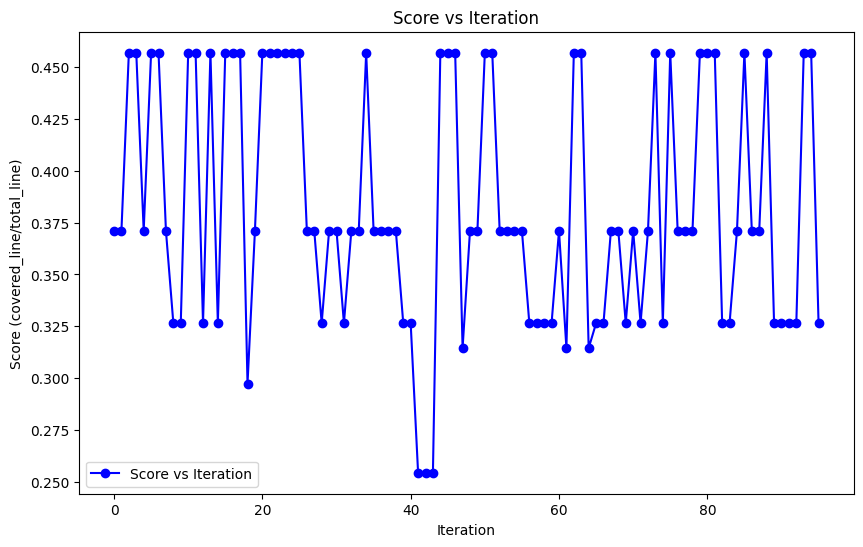

In [46]:
import matplotlib.pyplot as plt

# Your input list
data = queue.queue

# Step 1: Sort the list by iteration value (ascending)
data_sorted = sorted(data, key=lambda x: x[2])

# Step 2: Extract iteration and score values
iterations = [item[2] for item in data_sorted]
scores = [item[0] for item in data_sorted]

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label='Score vs Iteration')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Score (covered_line/total_line)')
plt.title('Score vs Iteration')
plt.legend()

# Show the plot
plt.show()


In [53]:
import requests
import unittest

# Initialize the semi-priority queue and fuzzer
queue = SemiPriorityQueue()
initial_seed = "http://example.com"  # Initial seed URL
fuzzer = SmartFuzzer(initial_seed)

# Run 100 fuzzing iterations
for _ in range(100):
    if queue.is_empty():
        new_seed = initial_seed  # Start with the initial seed
    else:
        new_seed = queue.peek()  # Get a prioritized input
    
    mutated_seed = fuzzer.mutate(new_seed)  # Mutate the seed
    
    # Update test.py with the new seed
    with open("test.py", "w") as test_file:
        test_file.write(f"""
import requests
import unittest

class TestRequestHandling(unittest.TestCase):
    def test_1(self):
        try:
            response = requests.get({repr(mutated_seed)})
            response.raise_for_status()  # Check for HTTP errors
        except requests.exceptions.RequestException as e:
            with open("validate_requests.txt", "a") as f:
                f.write(f"Error for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

if __name__ == "__main__":
    unittest.main()
    """)

    try:
        # Run tests and get coverage score
        coverage_score = get_coverage("requests", mutated_seed)
        # Push the new mutated input into the priority queue with its score
        if coverage_score is not None and coverage_score > 0:
            queue.push(mutated_seed, coverage_score)
    except Exception as e:
        with open("validate_requests.txt", "a") as f:
            f.write(f"Could not generate coverage for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

print("Fuzzing completed!")
print(queue.queue)


mutation type selected: delete
mutation type selected: delete
mutation type selected: insert
mutation type selected: append
mutation type selected: insert
mutation type selected: insert
mutation type selected: insert
mutation type selected: reverse
mutation type selected: reverse
mutation type selected: flip
mutation type selected: reverse
mutation type selected: append
mutation type selected: replace
mutation type selected: replace
mutation type selected: append
mutation type selected: insert
mutation type selected: append
mutation type selected: replace
mutation type selected: flip
mutation type selected: flip
mutation type selected: flip
mutation type selected: flip
mutation type selected: replace
mutation type selected: delete
mutation type selected: replace
Error getting coverage: Command '['pytest', '--cov=requests', '--cov-report=xml', '-s', '-q', '--tb=short', 'test.py']' returned non-zero exit status 2. for input: e.t{p:/exaplh.c(om
mutation type selected: replace
mutation typ

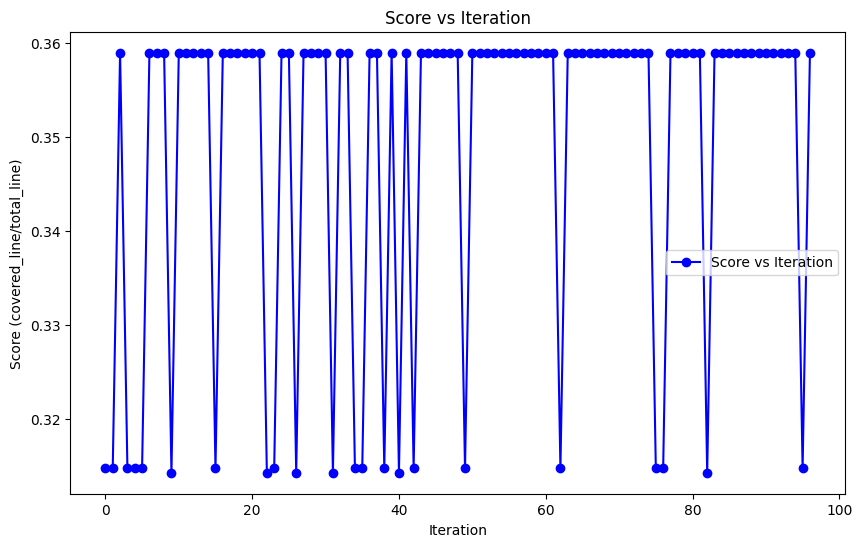

In [54]:
import matplotlib.pyplot as plt

# Your input list
data = queue.queue

# Step 1: Sort the list by iteration value (ascending)
data_sorted = sorted(data, key=lambda x: x[2])

# Step 2: Extract iteration and score values
iterations = [item[2] for item in data_sorted]
scores = [item[0] for item in data_sorted]

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label='Score vs Iteration')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Score (covered_line/total_line)')
plt.title('Score vs Iteration')
plt.legend()

# Show the plot
plt.show()

In [55]:
from bs4 import BeautifulSoup
import unittest

# Initialize the semi-priority queue and fuzzer
queue = SemiPriorityQueue()
initial_seed = "<html><body><p>Initial test content</p></body></html>"  # Initial seed HTML
fuzzer = SmartFuzzer(initial_seed)

# Run 100 fuzzing iterations
for _ in range(100):
    if queue.is_empty():
        new_seed = initial_seed  # Start with the initial seed
    else:
        new_seed = queue.peek()  # Get a prioritized input
    
    mutated_seed = fuzzer.mutate(new_seed)  # Mutate the seed
    
    # Update test.py with the new seed
    with open("test.py", "w") as test_file:
        test_file.write(f"""
from bs4 import BeautifulSoup
import unittest

class TestBeautifulSoupParsing(unittest.TestCase):
    def test_1(self):
        try:
            soup = BeautifulSoup({repr(mutated_seed)}, 'html.parser')
            # Check if parsing the HTML creates a valid BeautifulSoup object
            if soup is None:
                raise ValueError("Invalid HTML structure")
        except Exception as e:
            with open("validate_bs4.txt", "a") as f:
                f.write(f"Error for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

if __name__ == "__main__":
    unittest.main()
    """)

    try:
        # Run tests and get coverage score
        coverage_score = get_coverage("bs4", mutated_seed)
        # Push the new mutated input into the priority queue with its score
        if coverage_score is not None and coverage_score > 0:
            queue.push(mutated_seed, coverage_score)
    except Exception as e:
        with open("validate_bs4.txt", "a") as f:
            f.write(f"Could not generate coverage for input:\\n\\n{repr(mutated_seed)}\\n\\nError: {{str(e)}}\\n")

print("Fuzzing completed!")
print(queue.queue)


mutation type selected: reverse
mutation type selected: append
mutation type selected: reverse
mutation type selected: insert
Error getting coverage: Command '['pytest', '--cov=bs4', '--cov-report=xml', '-s', '-q', '--tb=short', 'test.py']' returned non-zero exit status 2. for input: >lmth/<>ydob/<>p/<tnet'noc tset laitinI>p<>ydob<>lmth<t
mutation type selected: reverse
mutation type selected: append
mutation type selected: replace
mutation type selected: delete
mutation type selected: append
mutation type selected: append
mutation type selected: reverse
mutation type selected: delete
mutation type selected: append
mutation type selected: delete
mutation type selected: reverse
mutation type selected: replace
mutation type selected: replace
mutation type selected: delete
mutation type selected: reverse
mutation type selected: delete
mutation type selected: insert
mutation type selected: delete
mutation type selected: replace
mutation type selected: replace
mutation type selected: flip
m

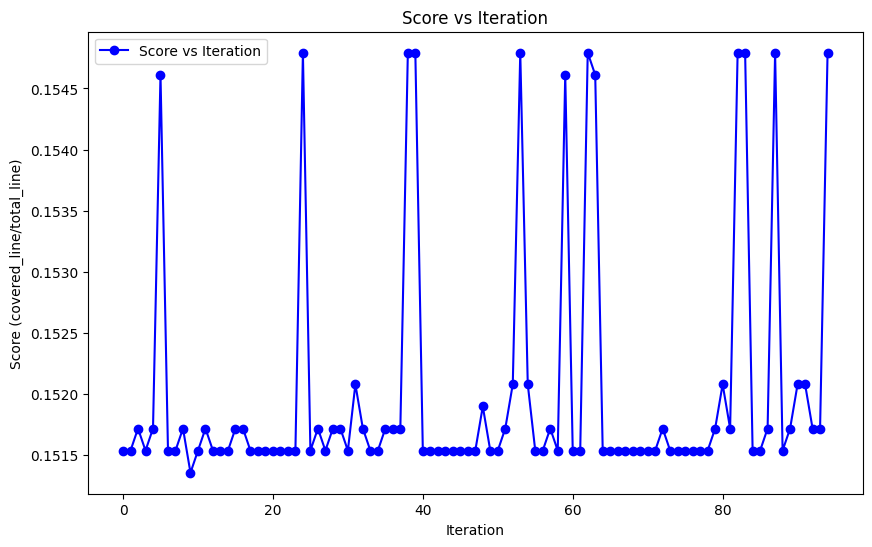

In [56]:
import matplotlib.pyplot as plt

# Your input list
data = queue.queue

# Step 1: Sort the list by iteration value (ascending)
data_sorted = sorted(data, key=lambda x: x[2])

# Step 2: Extract iteration and score values
iterations = [item[2] for item in data_sorted]
scores = [item[0] for item in data_sorted]

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label='Score vs Iteration')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Score (covered_line/total_line)')
plt.title('Score vs Iteration')
plt.legend()

# Show the plot
plt.show()